In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

## Helper functions

In [2]:
#Helper function to get nwbfile names, session ids and corresponding ROI numbers (same order)
def getNWBinfo(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
        lines = []
        sess_ids = []
        planes = []
	
        df = pd.read_csv(mouse_csv_path, usecols = ['sessid','line','runtype','plane'])

        #Getting all prod data
        for row, curr_type in enumerate(df.runtype):
                if curr_type == 'prod': 
                        lines.append(df.line[row])
                        sess_ids.append(str(df.sessid[row]))
                        planes.append(df.plane[row])
        
        assert len(lines)==len(sess_ids)==len(planes)==50, "Error in getting session info." 

        return sess_ids, planes, lines

#Helper function to get nwbfile names, session ids and corresponding ROI numbers (same order)
def getNWBinfo_roi(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
        lines = []
        sess_ids = []
        planes = []
        n_rois = []
        n_rois_soma = []
        n_rois_dend = []
	
        df = pd.read_csv(mouse_csv_path, usecols = ['sessid','line','runtype','plane','nrois'])

        #Getting all prod data
        for row, curr_type in enumerate(df.runtype):
                if curr_type == 'prod': 
                        lines.append(df.line[row])
                        sess_ids.append(str(df.sessid[row]))
                        planes.append(df.plane[row])
                        n_rois.append(df.nrois[row])

                        if df.plane[row] == 'soma':
                                n_rois_soma.append(df.nrois[row])
                        else:
                                n_rois_dend.append(df.nrois[row])
        
        assert len(lines)==len(sess_ids)==len(planes)==50, "Error in getting session info." 

        return sess_ids, planes, lines, n_rois, n_rois_soma, n_rois_dend


def get_diff_sess_ids():
        sess_ids, planes, lines = getNWBinfo()
        dend_sess_ids = []
        soma_sess_ids = []
        L23_sess_ids  = []
        L5_sess_ids = []

        for count, curr_sess_id in enumerate(sess_ids):
                if planes[count] == 'soma':
                        soma_sess_ids.append(curr_sess_id)
                else:
                        dend_sess_ids.append(curr_sess_id)

                if lines[count] == 'L23-Cux2':
                        L23_sess_ids.append(curr_sess_id)
                else:
                        L5_sess_ids.append(curr_sess_id)
        
        return dend_sess_ids, soma_sess_ids, L23_sess_ids, L5_sess_ids

     

In [3]:
def getNWBfilenames(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
    filenames = []
    sess_ids = []
    num_rois = []
    lines = []
    planes = []

    df = pd.read_csv(mouse_csv_path, usecols = ['sessid','mouseid','runtype','nrois','line','plane'])

    #Getting all prod data
    for row, curr_type in enumerate(df.runtype):
        if curr_type == 'prod': 
            #f_name = source_dir+"/sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            f_name = "sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            filenames.append(f_name)
            sess_ids.append(df.sessid[row])
            num_rois.append(df.nrois[row])
            lines.append(df.line[row])
            planes.append(df.plane[row])

    return filenames,sess_ids, num_rois, lines, planes

def check_nan(array):
    nan_indices = np.isnan(array)

    if np.any(nan_indices):
        non_nan_indices = ~nan_indices
        x = np.where(non_nan_indices)[0]
        y = array[non_nan_indices]
        
        # Use interpolation only if there are non-NaN values
        if len(x) > 0:
            f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
            array[nan_indices] = f(np.where(nan_indices)[0])

    return array

def get_cont_labels(nwbfile):
    behavior_module = nwbfile.processing['behavior']
    BehavioralTimeSeries= behavior_module.get_data_interface('BehavioralTimeSeries')
    pupiltracking = behavior_module.get_data_interface('PupilTracking')
    pupil_diameter = pupiltracking.time_series['pupil_diameter']
    pupil_diameter_data = np.copy(pupil_diameter.data)
    pupil_diameter_data = check_nan(pupil_diameter_data)
    behavior_timestamps= pupil_diameter.timestamps # Same timestamps as roi

    return pupil_diameter_data

def calculate_accuracy(prediction, valid_discrete_label):
    if len(prediction) != len(valid_discrete_label):
        return "Error: Arrays have different lengths."

    matches = sum(p == v for p, v in zip(prediction, valid_discrete_label))
    accuracy = matches / len(prediction)
    return accuracy

def get_diff_sess_ids():
        filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()
        dend_sess_ids = []
        soma_sess_ids = []
        L23_sess_ids  = []
        L5_sess_ids = []

        for count, curr_sess_id in enumerate(sess_ids):
                if planes[count] == 'soma':
                        soma_sess_ids.append(str(curr_sess_id))
                else:
                        dend_sess_ids.append(str(curr_sess_id))

                if lines[count] == 'L23-Cux2':
                        L23_sess_ids.append(str(curr_sess_id))
                else:
                        L5_sess_ids.append(str(curr_sess_id))
        
        return dend_sess_ids, soma_sess_ids, L23_sess_ids, L5_sess_ids

In [4]:
def get_acc_for_one_sess(combined_df,sess_id):
    condition = (combined_df["sess_id"] == sess_id)
    accs = combined_df.loc[condition,"val_accs"]

    condition_soma = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "soma")
    condition_dend = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "dend")
    condition_L23 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L23-Cux2")
    condition_L5 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L5-Rbp4")

    accs_soma = combined_df.loc[condition_soma,"val_accs"]
    accs_dend = combined_df.loc[condition_dend,"val_accs"]
    accs_L23 = combined_df.loc[condition_L23,"val_accs"]
    accs_L5 = combined_df.loc[condition_L5,"val_accs"]

    return accs,accs_dend,accs_soma,accs_L5,accs_L23

def get_losses_for_one_sess(combined_df,sess_id):
    sess_id = int(sess_id)
    condition = (combined_df["sess_id"] == sess_id)
    losses = combined_df.loc[condition,"train_losses"]

    condition_soma = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "soma")
    condition_dend = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "dend")
    condition_L23 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L23-Cux2")
    condition_L5 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L5-Rbp4")

    losses_soma = combined_df.loc[condition_soma,"train_losses"]
    losses_dend = combined_df.loc[condition_dend,"train_losses"]
    losses_L23 = combined_df.loc[condition_L23,"train_losses"]
    losses_L5 = combined_df.loc[condition_L5,"train_losses"]

    return losses,losses_dend,losses_soma, losses_L5, losses_L23

In [5]:
sess_ids, planes, lines = getNWBinfo()
dend_sess_ids, soma_sess_ids, L23_sess_ids, L5_sess_ids = get_diff_sess_ids()

In [6]:

def get_accs(df, sessions):
    accs_list = []
    for curr_sess_id in sessions:
        col_name = "val/session_{}_accuracy_gabor_orientation".format(curr_sess_id)
        curr_accs = np.array(df[col_name].values)

        accs_list.append(curr_accs)

    return np.array(accs_list)

def get_mean_std(accs_arr):
    accs_std = np.std(accs_arr)
    accs_avg = np.mean(accs_arr)

    print("all_std: ",accs_std)
    print("all_avg: ",accs_avg)


    dend_accs = []
    soma_accs = []

    for count, curr_sess_id in enumerate(sess_ids):
        if planes[count] == "soma":
            soma_accs.append(accs_arr[count])
        else:
            dend_accs.append(accs_arr[count])

    dend_accs = np.array(dend_accs)
    soma_accs = np.array(soma_accs)

    accs_soma_std = np.std(soma_accs)
    accs_soma_avg = np.mean(soma_accs)
    accs_dend_std = np.std(dend_accs)
    accs_dend_avg = np.mean(dend_accs)

    print("soma std: ",accs_soma_std)
    print("soma avg: ",accs_soma_avg)
    print("dend std: ",accs_dend_std)
    print("soma avg: ",accs_dend_avg)

In [66]:
# plot
def plot_2_sess(sess_1_acc, sess_2_acc, sess_1_label, sess_2_label, n_rois, epoch):
    # Create scatter plot with variable point sizes
    plt.scatter(sess_1_acc, sess_2_acc, 
                s=n_rois,  # Point sizes are set here
                label='num_rois', alpha=0.5)  # alpha for point transparency

    max_value = max(max(sess_1_acc), max(sess_2_acc))
    min_value = min(min(sess_1_acc), min(sess_2_acc))
    plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='-', linewidth=2)

    # Customize the plot
    plt.xlabel(sess_1_label)
    plt.ylabel(sess_2_label)
    plt.title('{} and {} Performance Comparison ({})'.format(sess_1_label,sess_2_label, epoch))
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## Multi-sess poyo_single_sess_model

In [8]:
csv_file_path = '/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/multi_sess_combined_losses.csv'
key_columns = ["epoch", "IMPORTANT - multi_sess - train_loss"]

### Train loss

In [10]:
train_df = pd.read_csv(csv_file_path, usecols=["epoch", "IMPORTANT - multi_sess - train_loss"])
roi_embedding_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/roi_embed_loss_combined.csv", usecols=["epoch", "train_loss"])
#within_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/within-sess/combined_train_losses.csv")
#dend_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/dend_combined_loss.csv")
#soma_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/soma_combined_loss.csv")

In [13]:
#min_epoch = min(train_df["epoch"].values[-1],dend_loss_df["epoch"].values[-1], soma_loss_df["epoch"].values[-1])
min_epoch = min(train_df["epoch"].values[-1],roi_embedding_loss_df["epoch"].values[-1])
print(min_epoch)

1358


In [14]:
#Get all validation accs and put in a 2d np array (num_sess(50), num_epochs)
#epochs = combined_val_df["epoch"] #x-axis

accs_list = []
accs_dend_list = []
accs_soma_list = []
accs_L23_list = []
accs_L5_list = []

for sess_id in tqdm(sess_ids):
    #accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_acc_for_one_sess(combined_val_df,sess_id)
    accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_losses_for_one_sess(train_df,sess_id)

    accs_list.append(accs)

    if len(accs_soma) != 0:
        accs_soma_list.append(accs_soma)
    else:
        accs_dend_list.append(accs_dend)
    
    if len(accs_L23) != 0:
        accs_L23_list.append(accs_L23)
    else:
        accs_L5_list.append(accs_L5)


  0%|          | 0/50 [00:00<?, ?it/s]

KeyError: 'sess_id'

In [21]:
within_sess_losses_all = np.array(accs_list)
within_sess_losses_dend = np.array(accs_dend_list)
within_sess_losses_soma = np.array(accs_soma_list)

In [16]:

# Define your window size for smoothing
window_size = 20  # You can adjust this value

# Smoothing the data
smooth_all_sessions = moving_average(train_df["IMPORTANT - multi_sess - train_loss"][:min_epoch], window_size)
smooth_all_sessions_ROI = moving_average(roi_embedding_loss_df["train_loss"][:min_epoch], window_size)

#smooth_dend_sessions = moving_average(dend_loss_df["multi_sess_dend - train_loss"][:min_epoch], window_size)
#smooth_soma_sessions = moving_average(soma_loss_df["multi_sess_soma - train_loss"][:min_epoch], window_size)


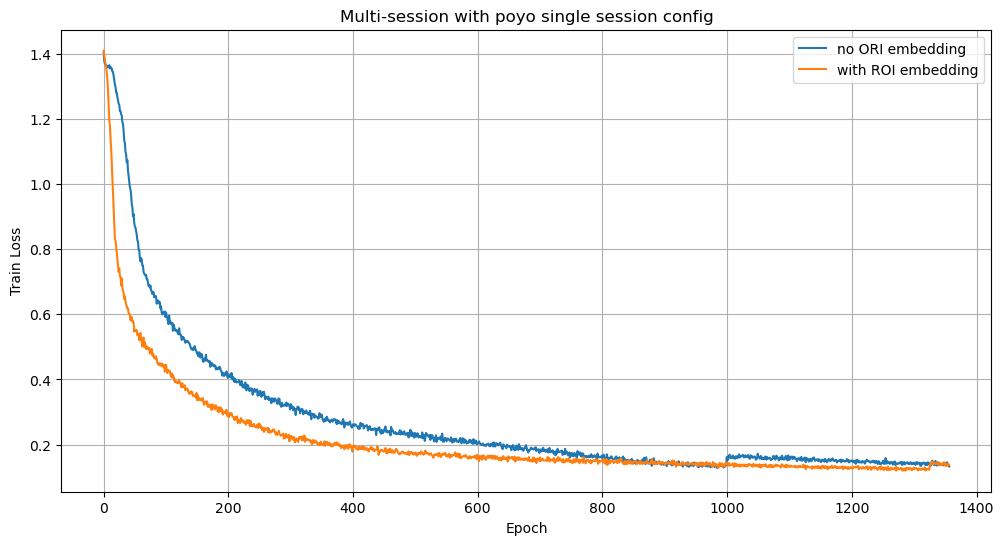

In [15]:

# Plotting the specified columns
plt.figure(figsize=(12, 6))
plt.plot(train_df["epoch"][:min_epoch], train_df["IMPORTANT - multi_sess - train_loss"][:min_epoch], label='no ORI embedding')
plt.plot(roi_embedding_loss_df["epoch"][:min_epoch], roi_embedding_loss_df["train_loss"][:min_epoch], label='with ROI embedding')
#plt.plot(dend_loss_df["epoch"][:min_epoch], dend_loss_df["multi_sess_dend - train_loss"][:min_epoch], label='dend sessions only')
#plt.plot(soma_loss_df["epoch"][:min_epoch], soma_loss_df["multi_sess_soma - train_loss"][:min_epoch], label = 'soma sessions only')
#plt.plot(within_loss_df["epoch"][:700], np.mean(within_sess_losses_all,axis=0), label = 'within sessions all')
#plt.plot(within_loss_df["epoch"][:700], np.mean(within_sess_losses_dend,axis=0), label = 'within sessions dend')
#plt.plot(within_loss_df["epoch"][:700], np.mean(within_sess_losses_soma,axis=0), label = 'within sessions soma')


plt.title("Multi-session with poyo single session config")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.legend()
plt.show()

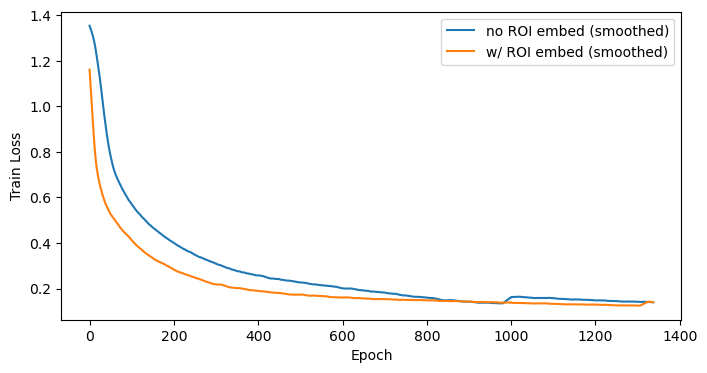

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(train_df["epoch"][:min_epoch - window_size + 1], smooth_all_sessions, label='no ROI embed (smoothed)')
plt.plot(train_df["epoch"][:min_epoch - window_size + 1], smooth_all_sessions_ROI, label='w/ ROI embed (smoothed)')
#plt.plot(dend_loss_df["epoch"][:min_epoch - window_size + 1], smooth_dend_sessions, label='dend sessions only (smoothed)')
#plt.plot(soma_loss_df["epoch"][:min_epoch - window_size + 1], smooth_soma_sessions, label='soma sessions only (smoothed)')

#plt.title("Multi-session with Poyo Single Session Config - Smoothed")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
#plt.grid(True)
plt.legend()
plt.show()

### Val

In [8]:

val_dend_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/dend_combined_vals.csv")
val_soma_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/soma_combined_vals.csv")

val_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/multi_sess_combined_vals.csv")

In [9]:
#Get all accuracies
all_accs_list = get_accs(val_df,sess_ids)


In [10]:
soma_accs_list = get_accs(val_soma_df, soma_sess_ids)
dend_accs_list = get_accs(val_dend_df, dend_sess_ids)

In [52]:
dend_accs_list.shape[1]

210

In [11]:
all_soma_accs_list = get_accs(val_df, soma_sess_ids)
all_dend_accs_list = get_accs(val_df, dend_sess_ids)

all_dend_accs_list_avg = np.mean(all_dend_accs_list, axis = 0)
all_soma_accs_list_avg = np.mean(all_soma_accs_list, axis = 0)

In [47]:
min_epoch_num = min(soma_accs_list.shape[1],dend_accs_list.shape[1],all_accs_list.shape[1])
print(min_epoch_num*10)

acc_final_all_soma = all_soma_accs_list[:, min_epoch_num-1]
acc_final_all_dend = all_dend_accs_list[:, min_epoch_num-1]
acc_final_soma = soma_accs_list[:, min_epoch_num-1]
acc_final_dend = dend_accs_list[:, -1]

1580


In [33]:
acc_final_soma.shape

(22,)

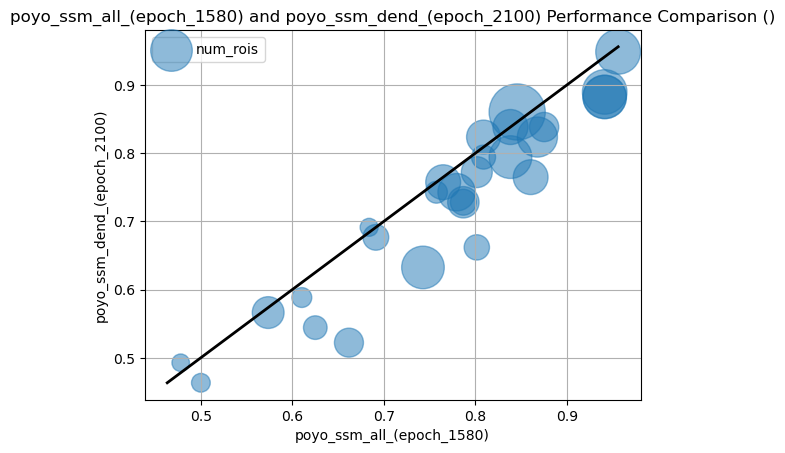

In [54]:
#def plot_2_sess(sess_1_acc, sess_2_acc, sess_1_label, sess_2_label, n_rois):
sess_ids, planes, lines, n_rois, n_rois_soma, n_rois_dend = getNWBinfo_roi()
plot_2_sess(acc_final_all_dend, acc_final_dend, 'poyo_ssm_all_(epoch_1580)', 'poyo_ssm_dend_(epoch_2100)', np.array(n_rois_dend), '')

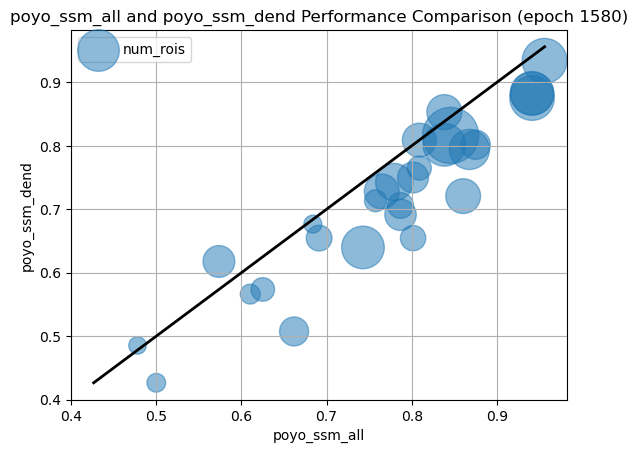

In [46]:
#def plot_2_sess(sess_1_acc, sess_2_acc, sess_1_label, sess_2_label, n_rois):
sess_ids, planes, lines, n_rois, n_rois_soma, n_rois_dend = getNWBinfo_roi()
plot_2_sess(acc_final_all_dend, acc_final_dend, 'poyo_ssm_all', 'poyo_ssm_dend', np.array(n_rois_dend), min_epoch_num*10)

In [13]:
np.shape(val_df["epoch"].values)

(158,)

In [14]:
all_accs_list_avg = np.mean(all_accs_list, axis = 0)
dend_accs_list_avg = np.mean(dend_accs_list, axis = 0)
soma_accs_list_avg = np.mean(soma_accs_list, axis = 0)

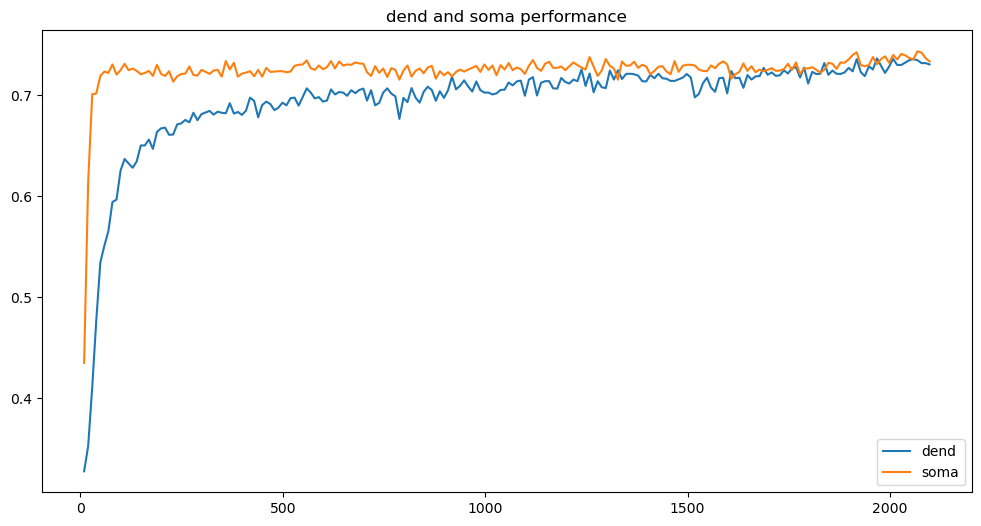

In [24]:
plt.figure(figsize=(12, 6))

#plt.plot(val_df["epoch"].values, all_soma_accs_list_avg, label = "all_soma")
#plt.plot(val_df["epoch"].values, all_dend_accs_list_avg, label = "all_dend")
plt.plot(val_dend_df["epoch"].values, dend_accs_list_avg, label = "dend")
plt.plot(val_soma_df["epoch"].values, soma_accs_list_avg, label = "soma")
plt.title("dend and soma performance")
plt.legend()

plt.show()

In [46]:
#avg values
print(all_accs_list_avg[-1])
print(dend_accs_list_avg[-1])
print(soma_accs_list_avg[-1])

0.7444117644429207
0.7303046232887677
0.7332887717268683


In [90]:
np.std(soma_accs_list[:,-1])

0.18837255137955705

In [15]:
all_accs_last = all_accs_list[:,-1]
print(all_accs_last)

[0.83823532 0.66911763 0.70588237 0.74264705 0.625      0.57352942
 0.7647059  0.83823532 0.80882353 0.91911763 0.74264705 0.66911763
 0.74264705 0.47058824 0.56617647 0.95588237 0.83823532 0.86764705
 0.69117647 0.68382353 0.75735295 0.8602941  0.78676468 0.78676468
 0.31617647 0.6102941  0.64705884 0.6102941  0.47794119 0.5
 0.77941179 0.80882353 0.80147058 0.84558821 0.875      0.80147058
 0.66176468 0.94117647 0.94117647 0.94117647 0.81617647 0.6397059
 0.79411763 0.83088237 0.83088237 0.875      0.94117647 0.8897059
 0.91176468 0.22794117]


In [17]:
filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()

In [60]:
def get_mean_std(accs_arr):
    accs_std = np.std(accs_arr)
    accs_avg = np.mean(accs_arr)

    print("all_std: ",accs_std)
    print("all_avg: ",accs_avg)


    dend_accs = []
    soma_accs = []

    for count, curr_sess_id in enumerate(sess_ids):
        if planes[count] == "soma":
            soma_accs.append(accs_arr[count])
        else:
            dend_accs.append(accs_arr[count])

    dend_accs = np.array(dend_accs)
    soma_accs = np.array(soma_accs)

    accs_soma_std = np.std(soma_accs)
    accs_soma_avg = np.mean(soma_accs)
    accs_dend_std = np.std(dend_accs)
    accs_dend_avg = np.mean(dend_accs)

    print("soma std: ",accs_soma_std)
    print("soma avg: ",accs_soma_avg)
    print("dend std: ",accs_dend_std)
    print("soma avg: ",accs_dend_avg)

In [19]:
get_mean_std(all_accs_last)

all_std:  0.15716426337973288
all_avg:  0.7444117644429207
soma std:  0.18478268280310362
soma avg:  0.7115641717206348
dend std:  0.12556448572239293
soma avg:  0.7702205872961453


## poyo 1

### Plotting loss

In [7]:
poyo_1_loss_df = pd.read_csv('/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/poyo_1_train_loss.csv', usecols=["epoch", "multi_sess_poyo_1 - train_loss"])
poyo_ssm_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/loss/multi_sess_combined_losses.csv", usecols=["epoch", "IMPORTANT - multi_sess - train_loss"])
within_loss_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/within-sess/combined_train_losses.csv")

In [16]:
poyo_1_loss = poyo_1_loss_df["multi_sess_poyo_1 - train_loss"].values
poyo_ssm_loss = poyo_ssm_loss_df['IMPORTANT - multi_sess - train_loss'].values

In [32]:
within_sess_loss_list = []
for curr_sess in sess_ids:
    within_sess_losses, _, _, _, _ = get_losses_for_one_sess(within_loss_df,curr_sess)
    within_sess_loss_list.append(within_sess_losses)

poyo_within_sess_loss = np.array(within_sess_loss_list)
poyo_within_sess_loss_avg = np.mean(poyo_within_sess_loss, axis=0)
within_std = np.std(poyo_within_sess_loss, axis = 0)

In [34]:
print(within_std.shape)

(700,)


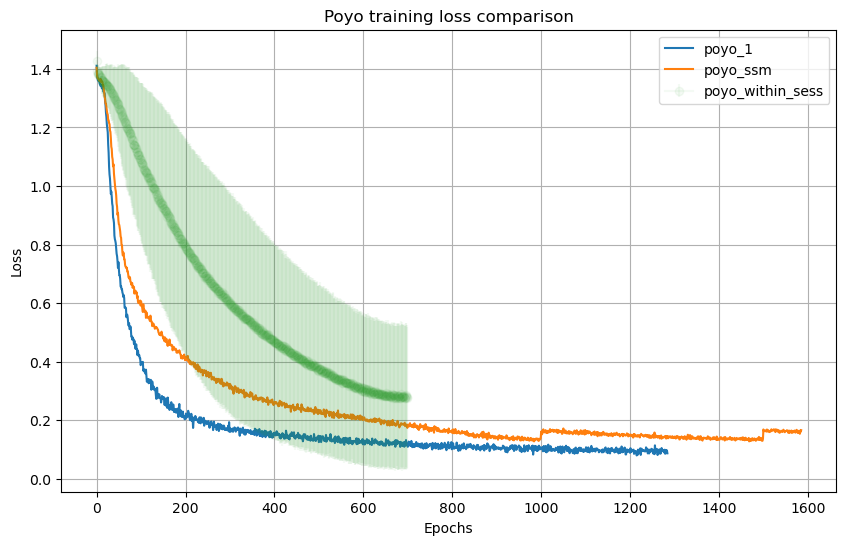

In [41]:

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot each array
plt.plot(poyo_1_loss, label='poyo_1')
plt.plot(poyo_ssm_loss, label='poyo_ssm')
#plt.plot(poyo_within_sess_loss_avg, label='poyo_within_sess (avg)')

plt.errorbar(range(len(poyo_within_sess_loss_avg)), poyo_within_sess_loss_avg, yerr=within_std, label='poyo_within_sess', fmt='-o', alpha = 0.05)

# Adding titles and labels
plt.title('Poyo training loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show legend
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Accs plots (Mehdi's suggested plot)

In [32]:
#Get all session final accuracies
#poyo_1_vals_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/poyo_1_vals.csv")
poyo_ssm_vals_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/multi_sess_combined_vals.csv")
#poyo_within_val_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/within-sess/combined_vals.csv")
poyo_roi_vals_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/roi_embed_vals_combined.csv")

In [33]:
#read all accuracies
poyo_roi_vals = get_accs(poyo_roi_vals_df,sess_ids)
poyo_ssm_vals = get_accs(poyo_ssm_vals_df,sess_ids)

In [34]:
poyo_roi_vals_final = poyo_roi_vals[:, -1]
poyo_ssm_vals_final = poyo_ssm_vals[:,-1]

In [35]:
poyo_roi_vals.shape

(50, 135)

In [12]:

accs_list = []
accs_dend_list = []
accs_soma_list = []
accs_L23_list = []
accs_L5_list = []

for sess_id in sess_ids:
    accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_acc_for_one_sess(poyo_within_val_df,int(sess_id))
    #accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_losses_for_one_sess(within_loss_df,sess_id)

    accs_list.append(accs)

    if len(accs_soma) != 0:
        accs_soma_list.append(accs_soma)
    else:
        accs_dend_list.append(accs_dend)
    
    if len(accs_L23) != 0:
        accs_L23_list.append(accs_L23)
    else:
        accs_L5_list.append(accs_L5)

within_accs_all = np.array(accs_list)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 296.35it/s]


In [13]:
within_accs_all_final = within_accs_all[:,-1]

In [62]:
#Get all ROI sizes for each session
sess_ids, planes, lines, n_rois, n_rois_soma, n_rois_dend = getNWBinfo_roi()

In [63]:
# plot
def plot_2_sess(sess_1_acc, sess_2_acc, sess_1_label, sess_2_label, n_rois):
    # Create scatter plot with variable point sizes
    plt.scatter(sess_1_acc, sess_2_acc, 
                s=n_rois,  # Point sizes are set here
                label='num_rois', alpha=0.5)  # alpha for point transparency

    max_value = max(max(sess_1_acc), max(sess_2_acc))
    min_value = min(min(sess_1_acc), min(sess_2_acc))
    plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='-', linewidth=2)

    # Customize the plot
    plt.xlabel(sess_1_label)
    plt.ylabel(sess_2_label)
    plt.title('{} and {} Performance Comparison'.format(sess_1_label,sess_2_label))
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

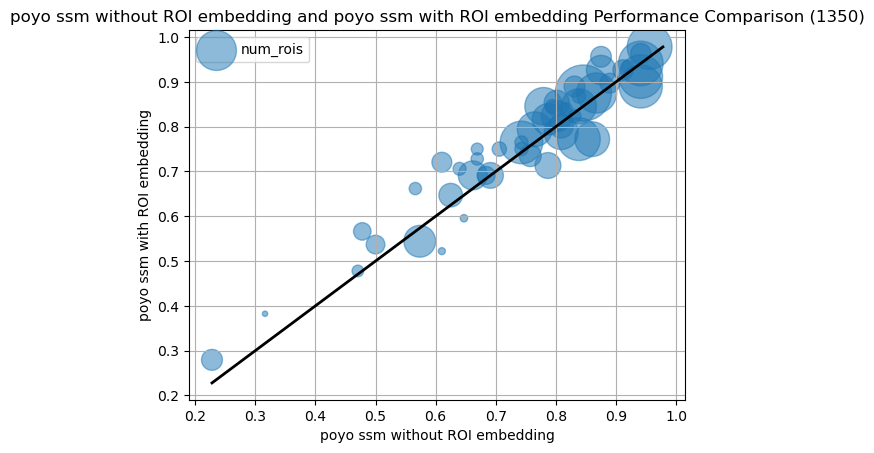

In [68]:
min_epoch_num= 135
plot_2_sess(poyo_ssm_vals_final,poyo_roi_vals_final, "poyo ssm without ROI embedding", "poyo ssm with ROI embedding", n_rois, min_epoch_num*10)

In [56]:
mlp_accs = np.array([83.45588235, 76.47058824, 75.73529412, 67.64705882, 63.60294118,
       56.98529412, 73.52941176, 81.61764706, 71.69117647, 94.48529412,
       81.25      , 71.32352941, 78.67647059, 51.10294118, 72.79411765,
       93.75      , 78.30882353, 84.55882353, 77.20588235, 68.75      ,
       71.32352941, 72.42647059, 77.57352941, 77.57352941, 44.48529412,
       52.94117647, 68.38235294, 58.08823529, 51.83823529, 56.25      ,
       83.82352941, 83.08823529, 73.52941176, 88.97058824, 76.10294118,
       75.        , 63.23529412, 84.55882353, 86.39705882, 92.27941176,
       80.88235294, 65.07352941, 83.08823529, 83.45588235, 88.97058824,
       94.48529412, 94.48529412, 90.80882353, 93.38235294, 31.25      ])
mlp_accs = mlp_accs/100

In [43]:
plot_2_sess(mlp_accs,poyo_1_vals_final, "MLP", "poyo_1", n_rois, min_epoch_num*10)

NameError: name 'mlp_accs' is not defined

In [36]:
poyo_roi_vals_avg_all_sess = np.mean(poyo_roi_vals, axis=0)
poyo_ssm_vals_avg_all_sess = np.mean(poyo_ssm_vals, axis=0)

poyo_roi_std = np.std(poyo_roi_vals, axis=0)
poyo_ssm_std = np.std(poyo_ssm_vals, axis=0)

In [59]:
poyo_roi_vals_avg_all_sess[-1]

0.7623529398441314

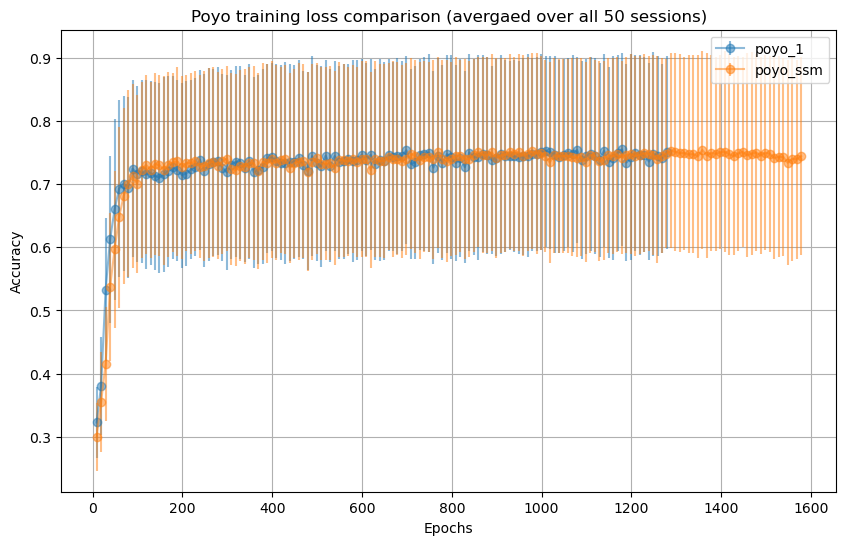

In [20]:

# Create a figure and axis
plt.figure(figsize=(10, 6))
plt.errorbar(poyo_1_vals_df['epoch'], poyo_1_vals_avg_all_sess, yerr=poyo_1_std, label='poyo_1', fmt='-o', alpha = 0.5)
plt.errorbar(poyo_ssm_vals_df['epoch'], poyo_ssm_vals_avg_all_sess, yerr=poyo_ssm_std, label='poyo_ssm', fmt='-o', alpha = 0.5)

# Adding titles and labels
plt.title('Poyo training loss comparison (avergaed over all 50 sessions)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show legend
plt.legend()
plt.grid()

# Show the plot
plt.show()

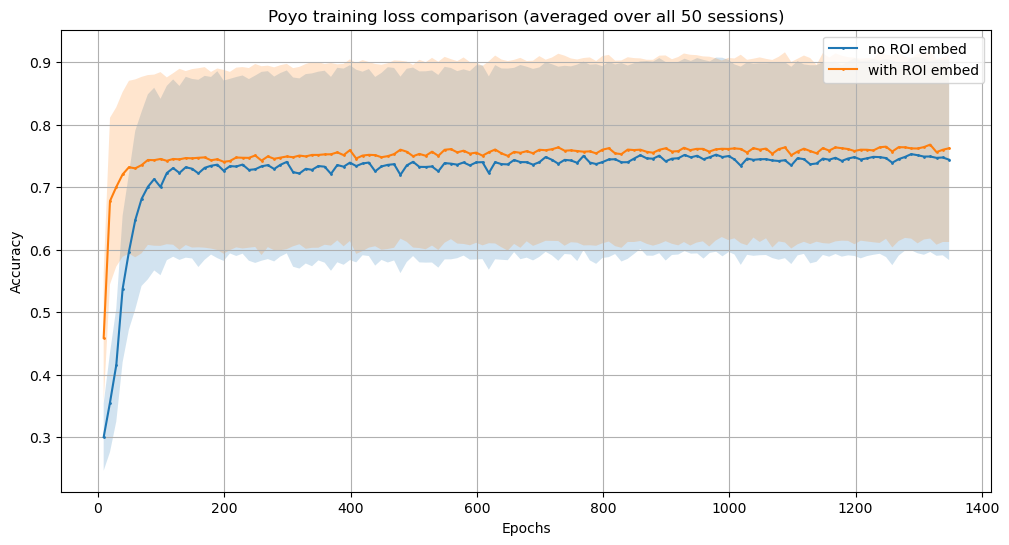

In [58]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the average values with smaller markers
plt.plot(poyo_ssm_vals_df['epoch'][:135], poyo_ssm_vals_avg_all_sess[:135], label='no ROI embed', marker='o', markersize=1)
plt.plot(poyo_roi_vals_df['epoch'], poyo_roi_vals_avg_all_sess, label='with ROI embed', marker='o', markersize=1)

# Create shaded error area for poyo_ssm
plt.fill_between(poyo_ssm_vals_df['epoch'][:135], 
                 poyo_ssm_vals_avg_all_sess[:135] - poyo_ssm_std[:135], 
                 poyo_ssm_vals_avg_all_sess[:135] + poyo_ssm_std[:135], 
                 alpha=0.2)

# Create shaded error area for poyo_1
plt.fill_between(poyo_roi_vals_df['epoch'], 
                 poyo_roi_vals_avg_all_sess - poyo_roi_std, 
                 poyo_roi_vals_avg_all_sess + poyo_roi_std, 
                 alpha=0.2)

# Adding titles and labels
plt.title('Poyo training loss comparison (averaged over all 50 sessions)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show legend
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [69]:
poyo_roi_vals_final

array([0.86764705, 0.75      , 0.75      , 0.7647059 , 0.64705884,
       0.54411763, 0.79411763, 0.84558821, 0.78676468, 0.93382353,
       0.7647059 , 0.72794116, 0.75      , 0.47794119, 0.66176468,
       0.97794116, 0.77205884, 0.875     , 0.69117647, 0.69117647,
       0.7352941 , 0.77205884, 0.71323532, 0.81617647, 0.38235295,
       0.52205884, 0.59558821, 0.72058821, 0.56617647, 0.53676468,
       0.84558821, 0.80147058, 0.85294116, 0.875     , 0.92647058,
       0.82352942, 0.69117647, 0.8897059 , 0.94117647, 0.91176468,
       0.83823532, 0.70588237, 0.84558821, 0.82352942, 0.8897059 ,
       0.95588237, 0.96323532, 0.89705884, 0.92647058, 0.27941176])

In [71]:
np.std(poyo_roi_vals_final)

0.1501184652049713